In [8]:
from pathlib import Path
import pandas as pd

wt_data = pd.read_csv(Path("generated", "WyckoffTransformer_mp_20_biternary_relaxed.zip"), index_col="folder_ind")
wc_data = pd.read_csv(Path("generated", "WyCryst_mp_20_biternary.ehull.csv.gz"), index_col="folder_ind")

In [9]:
import gzip
import pickle
from wyckoff_transformer.evaluation import StatisticalEvaluator
with gzip.open(Path("cache", "mp_20_biternary", "data.pkl.gz"), "rb") as f:
    datasets_pd = pickle.load(f)
evaluator = StatisticalEvaluator(datasets_pd["test"], pd.concat([datasets_pd["train"], datasets_pd["val"]], axis=0))

In [10]:
from itertools import repeat
from ast import literal_eval
GENERATED_PATH = Path("generated")
wycryst_genes_raw = pd.read_csv(GENERATED_PATH / "WyCryst_mp_20_biternary.csv", index_col=0,
                            converters=dict(zip(
                                ("reconstructed_ratio1", "reconstructed_wyckoff", "str_wyckoff", "ter_sys"),
                                repeat(literal_eval, 4)
                            )))

In [11]:
import json
from typing import Dict
with gzip.open(GENERATED_PATH / "WyckoffTransformer_mp_20_biternary.json.gz", "rt") as f:
    generated_wyckoff_transformer = pd.read_json(f)
def check_novelty_record(record: Dict) -> bool:
    return evaluator.generated_to_fingerprint(record) not in evaluator.train_fingerprints
generated_wyckoff_transformer["is_novel"] = generated_wyckoff_transformer.apply(check_novelty_record, axis=1)


In [12]:
wt_data["is_novel"] = generated_wyckoff_transformer["is_novel"]
wt_data = wt_data[wt_data["is_novel"]]

In [13]:
from wyckoff_transformer.evaluation import wycryst_to_pyxtal_dict
def check_novelty_wycryst(record):
    pyxtal_dict = wycryst_to_pyxtal_dict(record)
    if pyxtal_dict is None:
        return False
    return evaluator.generated_to_fingerprint(pyxtal_dict) not in evaluator.train_fingerprints
wycryst_genes_raw['is_novel'] = wycryst_genes_raw.apply(check_novelty_wycryst, axis=1)
wycryst_genes_raw.reset_index(inplace=True, drop=True)
wc_data["is_novel"] = wycryst_genes_raw["is_novel"]
wc_data["reconstructed_formula"] = wycryst_genes_raw["reconstructed_formula"]
assert (wc_data["reconstructed_formula"] == wc_data["formula"].map(lambda x: x.replace(" ", ""))).all()
wc_data = wc_data.loc[wc_data["is_novel"]]

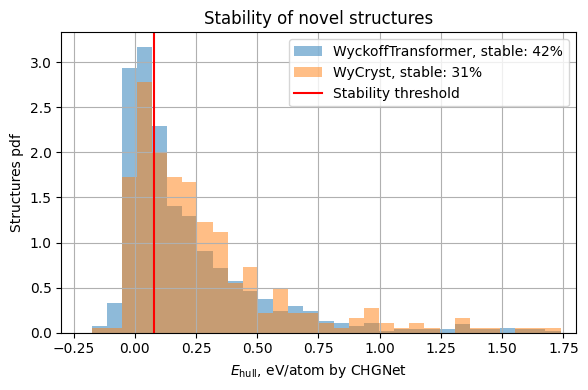

In [14]:
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots(figsize=(6, 4))
bins=np.linspace(-0.3, 1.8, 35)
stability_threshold = 0.08
wt_data.corrected_chgnet_ehull.hist(bins=bins, ax=ax,
    label=f"WyckoffTransformer, stable: {100*(wt_data.corrected_chgnet_ehull < stability_threshold).sum()/len(wt_data):.0f}%",
    color="tab:blue", density=True, alpha=0.5)
wc_data.corrected_chgnet_ehull.hist(bins=bins, ax=ax,
    label=f"WyCryst, stable: {100*(wc_data.corrected_chgnet_ehull < stability_threshold).sum()/len(wc_data):.0f}%",
    color="tab:orange", alpha=0.5, density=True)
ax.set_xlabel("$E_\\text{hull}$, eV/atom by CHGNet")
ax.set_ylabel("Structures pdf")
ax.axvline(stability_threshold, color="red", label="Stability threshold")
ax.set_xlim((-0.3, 1.8))
ax.set_title("Stability of novel structures")
ax.legend()
fig.tight_layout()
fig.savefig("plots/AI4AM_NeurIPS_2024/WyCryst_vs_WyckoffTransformer_stability.pdf")